In [1]:
### Import data
import pandas as pd

df = pd.read_csv('movie_ratings.csv', index_col='Unnamed: 0')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.head())

df = df[df['rating'] >= 4.0]

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating            timestamp  
0       3     4.0  1999-12-11 13:36:47  
1       6     5.0  1997-03-13 17:50:52  
2       8     4.0  1996-06-05 13:37:51  
3      10     4.0  1999-11-25 02:44:47  
4      11     4.5  2009-01-02 01:13:41  


In [3]:
### Format data
# Recover unique user IDs
user_id = df['userId'].unique()

# Create 'basket' of  movies for each user.
basket = [list(df[df['userId'] == u].title) for u in user_id]

print(basket[1])

['Toy Story (1995)', 'Sabrina (1995)', 'Sense and Sensibility (1995)', 'Mighty Aphrodite (1995)', "Mr. Holland's Opus (1995)", 'Up Close and Personal (1996)', 'Birdcage, The (1996)', 'Star Wars: Episode IV - A New Hope (1977)', 'Executive Decision (1996)', 'Primal Fear (1996)', 'Mission: Impossible (1996)', 'Dragonheart (1996)', 'Truth About Cats & Dogs, The (1996)', 'Nutty Professor, The (1996)']


In [5]:
#!pip install mlxtend

     ---------------------------------------- 1.4/1.4 MB 11.5 MB/s eta 0:00:00


In [6]:
# Transform data structure
from mlxtend.preprocessing import TransactionEncoder
encoder = TransactionEncoder()
transaction = encoder.fit(basket).transform(basket)
transaction = pd.DataFrame(transaction, columns = encoder.columns_) # use movie titles as column headers

transaction.head()

,$5 a Day (2008),$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),...,[REC] (2007),[REC]² (2009),"\\""Great Performances\""\"" Cats (1998)""",eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),À nous la liberté (Freedom for Us) (1931)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [7]:
### Filter itemsets using apriori / fpgrowth# max_len=2 means {apple}->{banana}
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(transaction, min_support = 0.05, max_len = 2, use_colnames = True)

In [8]:
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets = fpgrowth(transaction, min_support=0.05, max_len = 2, use_colnames = True)

In [9]:
### Generate rules
# Rules without any metric
rules = association_rules(frequent_itemsets, metric='support', min_threshold = 0.0)


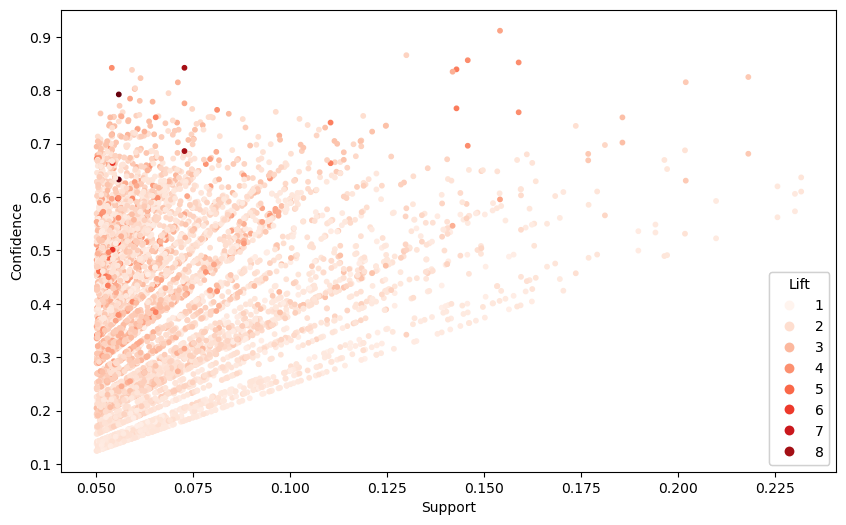

In [10]:
# Generate scatterplot using support, confidence, and lift to get a guidance on pruning criteria
from matplotlib import pyplot as plt
fig, ax = plt.subplots( figsize = (10,6))
scatter = ax.scatter(x = "support", y = "confidence", c = "lift", data = rules, cmap = 'Reds', s=10)
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Lift")
ax.add_artist(legend)
ax.set_xlabel('Support')
ax.set_ylabel('Confidence')
plt.show()

Support is low so maybe use confidence and lift 

In [11]:
# Prune rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=4)


In [12]:
### Visualize rules
## 1. Parallel coordinate plot to look at the 'network'
# Create coordinates to be used in the plot
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index

coords = rules[['antecedent','consequent','rule']]


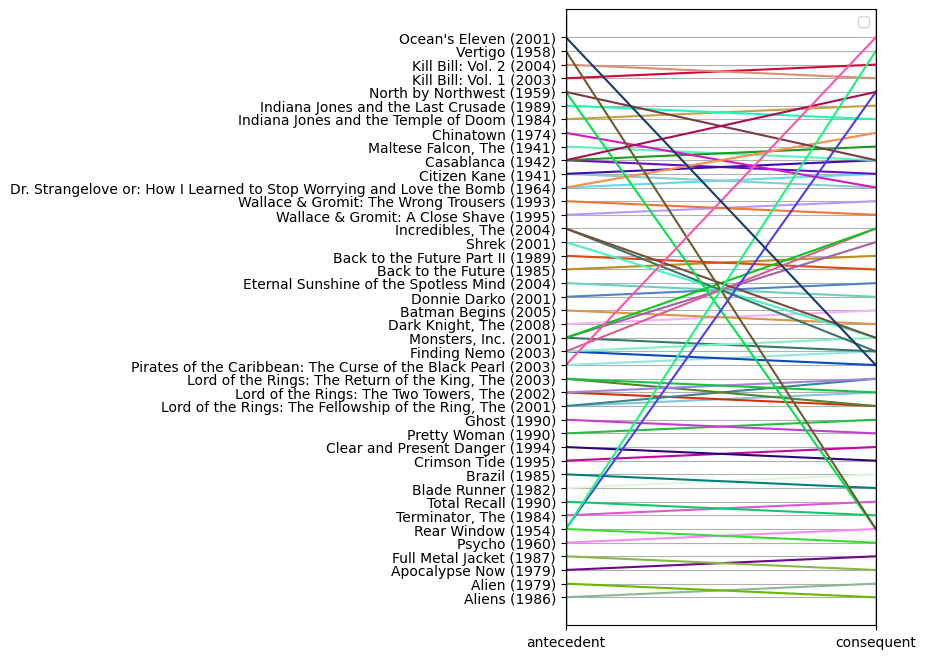

In [13]:
# Generate parallel coordinates plot
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()

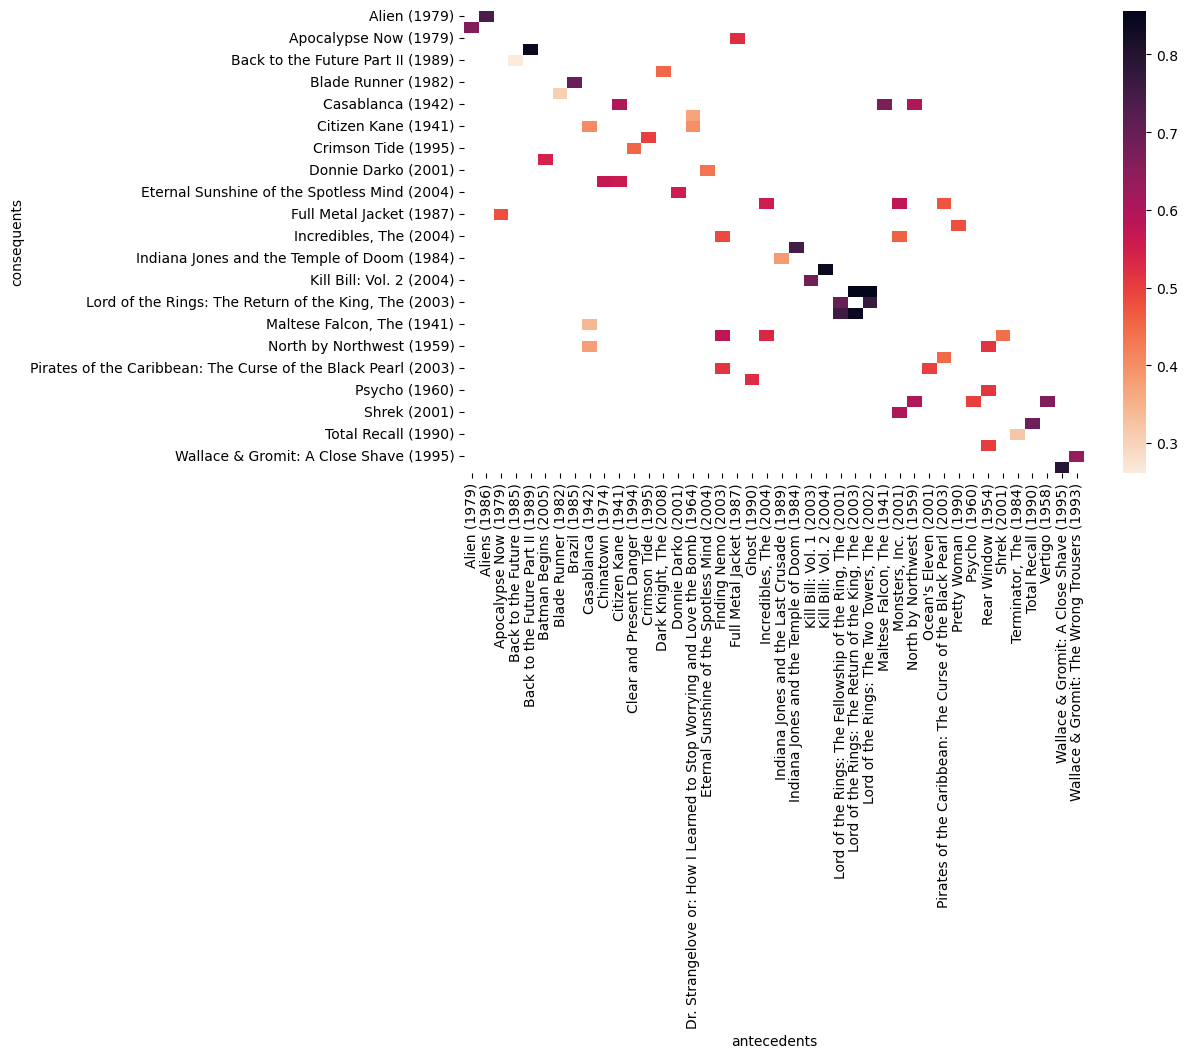

In [14]:
## 2. Heatmap to look at the intensity of each rule
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=4)

# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform antecedent, consequent, and confidence columns into matrix
confidence_table = rules.pivot(index='consequents', columns='antecedents', values='confidence')

# Generate heatmap
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(confidence_table, cmap = sns.cm.rocket_r)
plt.yticks(rotation=0)
plt.show() 

In [16]:
### Mini recommendation system
rules = association_rules(frequent_itemsets, metric='support', min_threshold = 0.0)

def movie_recommender(rules, movie, rec_count=1):
    sorted_rules = rules.sort_values("lift", ascending=False)    # rank rules based on lift
    recommendation_list = []       
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):         # We convert the values we have captured into a list.
            if j == movie:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"]))
    return recommendation_list[0:rec_count]


movie_recommender(rules, "Donnie Darko (2001)", 3)

[['Eternal Sunshine of the Spotless Mind (2004)'],
 ['Memento (2000)'],
 ['Fight Club (1999)']]